# Add objects to images

In [1]:
pip install opencv-python-headless matplotlib


Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import os
import re
import random
import sys
sys.path.append(os.path.abspath('src'))
import data_preparation as dp

In [3]:
# Load the image
image_path = './IMAGES_ATTACK/10_images_original/'
image = cv2.imread(image_path)

# Parse the XML file
xml_path = './PREDICTIONS_ATTACK/10_images_original/Annotations/'

image_folder = image_path
sentence_folder = './PREDICTIONS_ATTACK/10_images_original/Sentences/'
annotation_folder = xml_path
output_folder = "./IMAGES_ATTACK/add_object/10_images/"
object_images_folder = "./OBJECT_IMAGES/"

In [4]:
# Get the bounding box with the "person" object which has the the maximum area
bounding_boxes_to_add = dp.process_images(image_folder, sentence_folder, annotation_folder, output_folder)

['48220', '48220', '48220', '48220', '48220']
[(158, 46, 300, 283)]
['100072', '100072', '100072', '100072', '100072', '100072']
[(249, 84, 378, 260), (47, 95, 166, 290), (122, 134, 240, 304)]
['142054', '142054', '142054', '142059', '142054', '142054']
[(211, 125, 283, 319), (80, 128, 169, 348), (296, 106, 359, 320), (347, 219, 390, 311), (443, 176, 499, 311), (324, 222, 389, 311)]
['144551', '144551', '144551', '144552', '144551', '144551']
none
[(128, 66, 252, 328), (238, 58, 354, 318)]
['147590', '147590', '147593', '147590', '147590', '147590']
[(4, 125, 229, 431), (62, 154, 110, 278), (296, 167, 327, 290), (235, 159, 289, 303), (12, 165, 70, 301), (1, 152, 27, 270), (95, 149, 129, 241)]
['188511', '188510', '188510', '188510', '188511']
[(175, 57, 324, 334), (2, 82, 103, 158)]
['211901', '211901', '211904', '211901', '211904', '211906', '211901', '211904', '211901', '211908']
[(95, 151, 259, 493), (328, 136, 423, 455), (66, 266, 119, 289), (211, 255, 266, 273), (1, 159, 72, 498),

In [5]:
# remove black background in the images of objects
def remove_black_background(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Create a binary mask where black pixels are considered background
    _, mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    
    # Create 3-channel alpha mask
    alpha = cv2.merge([mask, mask, mask])
    
    # Add an alpha channel to the image
    b, g, r = cv2.split(image)
    rgba = [b, g, r, mask]
    image_with_alpha = cv2.merge(rgba, 4)
    
    return image_with_alpha

In [6]:
# function to insert the image of an object inside the bounding box
def insert_object(image, object_images_folder, bbox):
    image_with_object = image
    object_img = cv2.imread(object_images_folder, cv2.IMREAD_UNCHANGED)
    if object_img is None:
        print(f"Error: Image {object_images_folder} not found.")
        return

    object_img = remove_black_background(object_img)

    xmin, ymin, xmax, ymax = bbox
    bbox_width = xmax - xmin
    bbox_height = ymax - ymin
    insert_width = bbox_width // 2  # Cover at most 1/2 of the bounding box width
    insert_height = bbox_height // 5  # Cover at most 1/5 of the bounding box height

    # Resize insert_img to fit the bounding box 1/2 width and 1/5 height
    object_img_resized = cv2.resize(object_img, (insert_width, insert_height))

    # Insert the resized image into the topmost part of the bounding box
    insert_x_start = xmin + (bbox_width - insert_width) // 2
    # Handle alpha channel if present
    if object_img_resized.shape[2] == 4:
        alpha_s = object_img_resized[:, :, 3] / 255.0
        alpha_l = 1.0 - alpha_s

        for c in range(0, 3):
            image_with_object[ymin:ymin+insert_height, insert_x_start:insert_x_start+insert_width, c] = (alpha_s * object_img_resized[:, :, c] +
                                                                                             alpha_l * image_with_object[ymin:ymin+insert_height, insert_x_start:insert_x_start+insert_width, c])
    else:
        image_with_object[ymin:ymin+insert_height, insert_x_start:insert_x_start+insert_width] = object_img_resized
    return image_with_object    

In [7]:
def process_images_with_inserts(image_folder, sentence_folder, annotation_folder, output_folder, insert_images_folder):
    bounding_boxes_data = dp.process_images(image_folder, sentence_folder, annotation_folder, output_folder)
    processed_images = []

    for image_path, bboxes, image_id in bounding_boxes_data:
        insert_images = [os.path.join(insert_images_folder, f) for f in os.listdir(insert_images_folder) if f.endswith('.png')]
        
        if not insert_images:
            print(f"No insert images found in folder: {insert_images_folder}")
            continue
        
        insert_image_path = random.choice(insert_images)

        # Draw bounding boxes and insert random image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Image {image_path} not found.")
            continue
        
        max_bbox = max(bboxes, key=dp.calculate_area)
        image_with_object = insert_object(image, insert_image_path, max_bbox)

        output_filename = os.path.join(output_folder, f'output_{image_id}.jpg')
        cv2.imwrite(output_filename, image_with_object)
        print(f"Processed {image_id} and saved as {output_filename}")

        processed_images.append(image_with_object)
    return processed_images

In [8]:
processed_images = process_images_with_inserts(image_folder, sentence_folder, annotation_folder, output_folder, object_images_folder)

['48220', '48220', '48220', '48220', '48220']
[(158, 46, 300, 283)]
['100072', '100072', '100072', '100072', '100072', '100072']
[(249, 84, 378, 260), (47, 95, 166, 290), (122, 134, 240, 304)]
['142054', '142054', '142054', '142059', '142054', '142054']
[(211, 125, 283, 319), (80, 128, 169, 348), (296, 106, 359, 320), (347, 219, 390, 311), (443, 176, 499, 311), (324, 222, 389, 311)]
['144551', '144551', '144551', '144552', '144551', '144551']
none
[(128, 66, 252, 328), (238, 58, 354, 318)]
['147590', '147590', '147593', '147590', '147590', '147590']
[(4, 125, 229, 431), (62, 154, 110, 278), (296, 167, 327, 290), (235, 159, 289, 303), (12, 165, 70, 301), (1, 152, 27, 270), (95, 149, 129, 241)]
['188511', '188510', '188510', '188510', '188511']
[(175, 57, 324, 334), (2, 82, 103, 158)]
['211901', '211901', '211904', '211901', '211904', '211906', '211901', '211904', '211901', '211908']
[(95, 151, 259, 493), (328, 136, 423, 455), (66, 266, 119, 289), (211, 255, 266, 273), (1, 159, 72, 498),

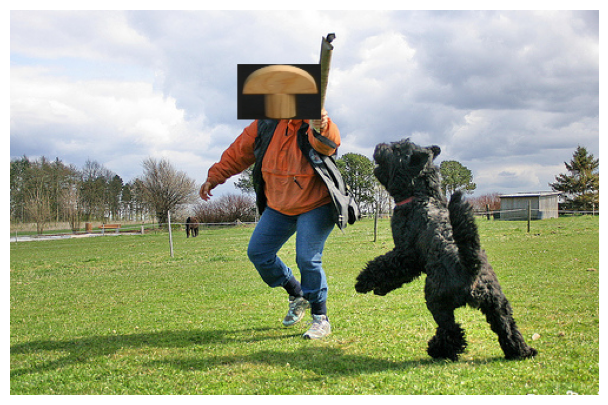

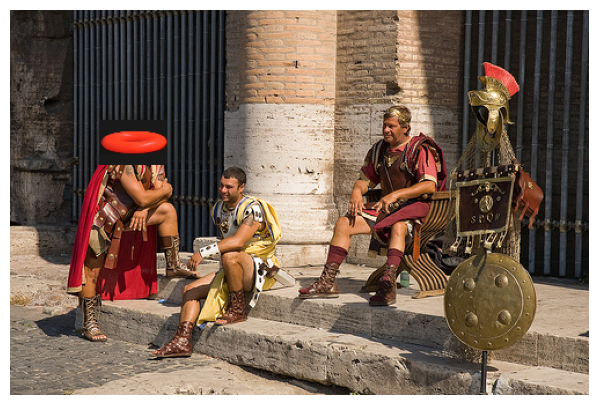

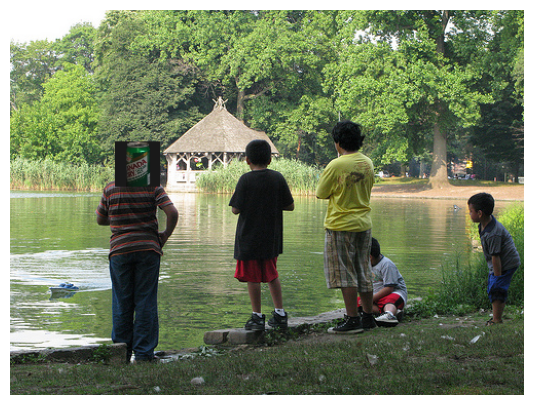

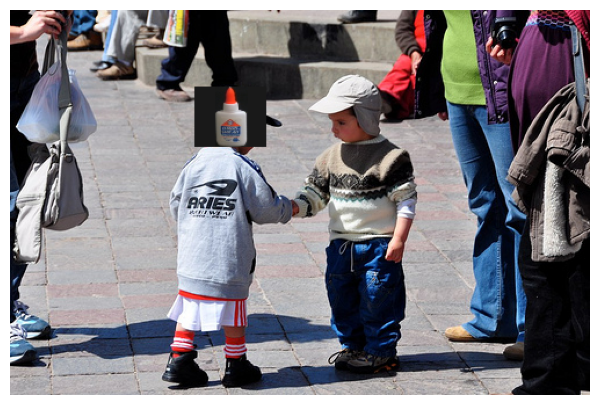

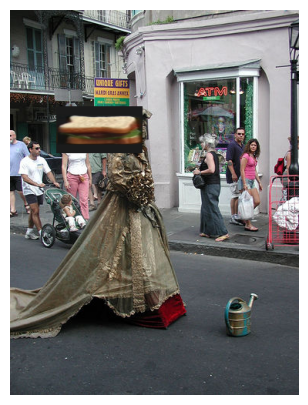

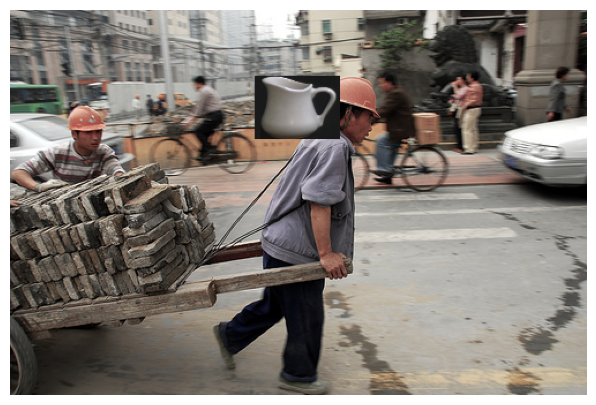

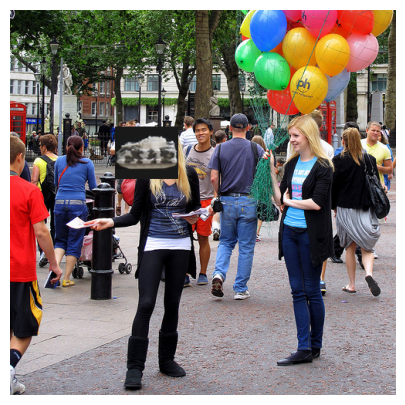

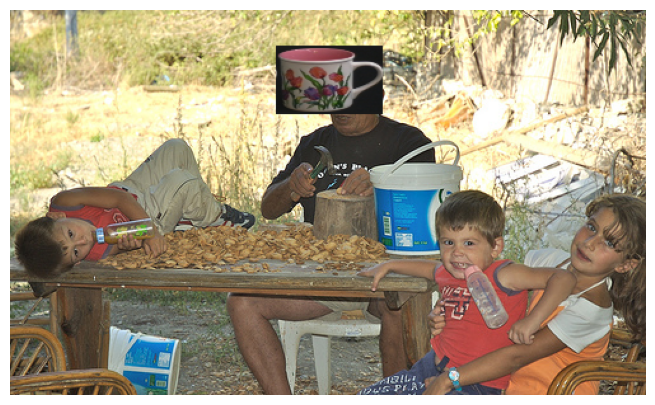

In [9]:
for image_with_insert in processed_images:
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(image_with_insert, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()